Polynomial Approximation
========

# Theory

**Polynomial approximation** aims to approximate a function $f(x)$ using a polynomial $p_n(x)$ of degree $n$. While Taylor series provides local approximation around a point, other polynomial bases like **Chebyshev polynomials** offer superior global approximation properties.

## Taylor Series vs. Chebyshev Approximation

**Taylor series** approximates a function around a single point $a$:
$$p_n(x) = \sum_{k=0}^n \frac{f^{(k)}(a)}{k!}(x-a)^k$$

This provides excellent accuracy near $a$ but can diverge far from it.

**Chebyshev approximation** distributes error more uniformly across the entire interval, providing near-optimal (minimax) approximation.

## Chebyshev Polynomials

**Chebyshev polynomials of the first kind** $T_n(x)$ are defined on $[-1, 1]$ by:
$$T_n(x) = \cos(n \arccos(x))$$

Or via the recurrence relation:
$$\begin{align}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2x T_n(x) - T_{n-1}(x)
\end{align}$$

The first few Chebyshev polynomials are:
- $T_0(x) = 1$
- $T_1(x) = x$
- $T_2(x) = 2x^2 - 1$
- $T_3(x) = 4x^3 - 3x$
- $T_4(x) = 8x^4 - 8x^2 + 1$

### Key Properties

1. **Orthogonality**: Chebyshev polynomials are orthogonal with respect to the weight $w(x) = \frac{1}{\sqrt{1-x^2}}$:
$$\int_{-1}^{1} \frac{T_m(x) T_n(x)}{\sqrt{1-x^2}} dx = \begin{cases} 0 & m \neq n \\ \pi & m = n = 0 \\ \pi/2 & m = n \neq 0 \end{cases}$$

2. **Bounded oscillation**: $|T_n(x)| \leq 1$ for $x \in [-1, 1]$

3. **Minimax property**: The polynomial $\frac{1}{2^{n-1}}T_n(x)$ has the smallest maximum absolute value among all monic polynomials of degree $n$ on $[-1, 1]$.

## Chebyshev Approximation

A function $f(x)$ can be approximated as:
$$f(x) \approx \sum_{k=0}^{n} c_k T_k(x)$$

The coefficients are computed via:
$$c_k = \frac{2}{\pi} \int_{-1}^{1} \frac{f(x) T_k(x)}{\sqrt{1-x^2}} dx$$

In practice, this integral is evaluated using **Chebyshev nodes**:
$$x_j = \cos\left(\frac{(2j+1)\pi}{2(n+1)}\right), \quad j = 0, 1, \ldots, n$$

# Implementation

## Imports

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## Parameters

In [12]:
# Target function to approximate
f = lambda x: np.exp(x)  # or try: 1/(1 + 25*x**2) (Runge's function)

# Approximation parameters
n_terms = 8  # number of Chebyshev terms
interval = [-1, 1]  # standard Chebyshev interval

## Algorithm

```mermaid
    flowchart LR
        nodes(Compute Chebyshev nodes) --> eval(Evaluate f at nodes)
        eval --> coeffs(Compute Chebyshev coefficients)
        coeffs --> approx(Construct approximation)
```

In [13]:
def chebyshev_nodes(n: int) -> np.ndarray:
    '''
    Compute Chebyshev nodes of the first kind.
    
    Args:
        n: Number of nodes
    
    Returns:
        Array of n Chebyshev nodes on [-1, 1]
    '''
    j = np.arange(n)
    return np.cos((2*j + 1) * np.pi / (2*n))

In [14]:
def chebyshev_polynomial(n: int, x: np.ndarray) -> np.ndarray:
    '''
    Evaluate Chebyshev polynomial T_n(x) using recurrence relation.
    
    Args:
        n: Degree of polynomial
        x: Points at which to evaluate
    
    Returns:
        Values of T_n(x)
    '''
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x.copy()
    else:
        T_prev2 = np.ones_like(x)   # T_0
        T_prev1 = x.copy()           # T_1
        for k in range(2, n + 1):
            T_curr = 2 * x * T_prev1 - T_prev2
            T_prev2 = T_prev1
            T_prev1 = T_curr
        return T_curr

In [15]:
def chebyshev_coefficients(f: Callable, n: int) -> np.ndarray:
    '''
    Compute Chebyshev expansion coefficients using discrete orthogonality.
    
    Args:
        f: Function to approximate
        n: Number of terms in approximation
    
    Returns:
        Array of n Chebyshev coefficients
    '''
    nodes = chebyshev_nodes(n)
    f_values = f(nodes)
    
    coeffs = np.zeros(n)
    for k in range(n):
        T_k = chebyshev_polynomial(k, nodes)
        coeffs[k] = (2.0 / n) * np.sum(f_values * T_k)
    
    coeffs[0] /= 2  # c_0 has factor 1/2
    return coeffs

In [16]:
def chebyshev_approximation(x: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    '''
    Evaluate Chebyshev approximation at given points.
    
    Args:
        x: Points at which to evaluate
        coeffs: Chebyshev coefficients
    
    Returns:
        Approximated function values
    '''
    result = np.zeros_like(x)
    for k, c in enumerate(coeffs):
        result += c * chebyshev_polynomial(k, x)
    return result

In [17]:
def taylor_approximation(x: np.ndarray, n: int, center: float = 0) -> np.ndarray:
    '''
    Taylor series approximation of exp(x) around center.
    
    Args:
        x: Points at which to evaluate
        n: Number of terms
        center: Expansion point
    
    Returns:
        Taylor approximation values
    '''
    result = np.zeros_like(x)
    for k in range(n):
        result += np.exp(center) * (x - center)**k / math.factorial(k)
    return result

## Results Visualization

We compare Chebyshev approximation with Taylor series for approximating $e^x$ on $[-1, 1]$.

In [18]:
# Compute approximations
coeffs = chebyshev_coefficients(f, n_terms)
x = np.linspace(-1, 1, 200)

y_true = f(x)
y_cheb = chebyshev_approximation(x, coeffs)
y_taylor = taylor_approximation(x, n_terms)

print(f"Chebyshev coefficients: {coeffs}")

Chebyshev coefficients: [1.26606588e+00 1.13031821e+00 2.71495340e-01 4.43368498e-02
 5.47424044e-03 5.42926287e-04 4.49767724e-05 3.18739969e-06]


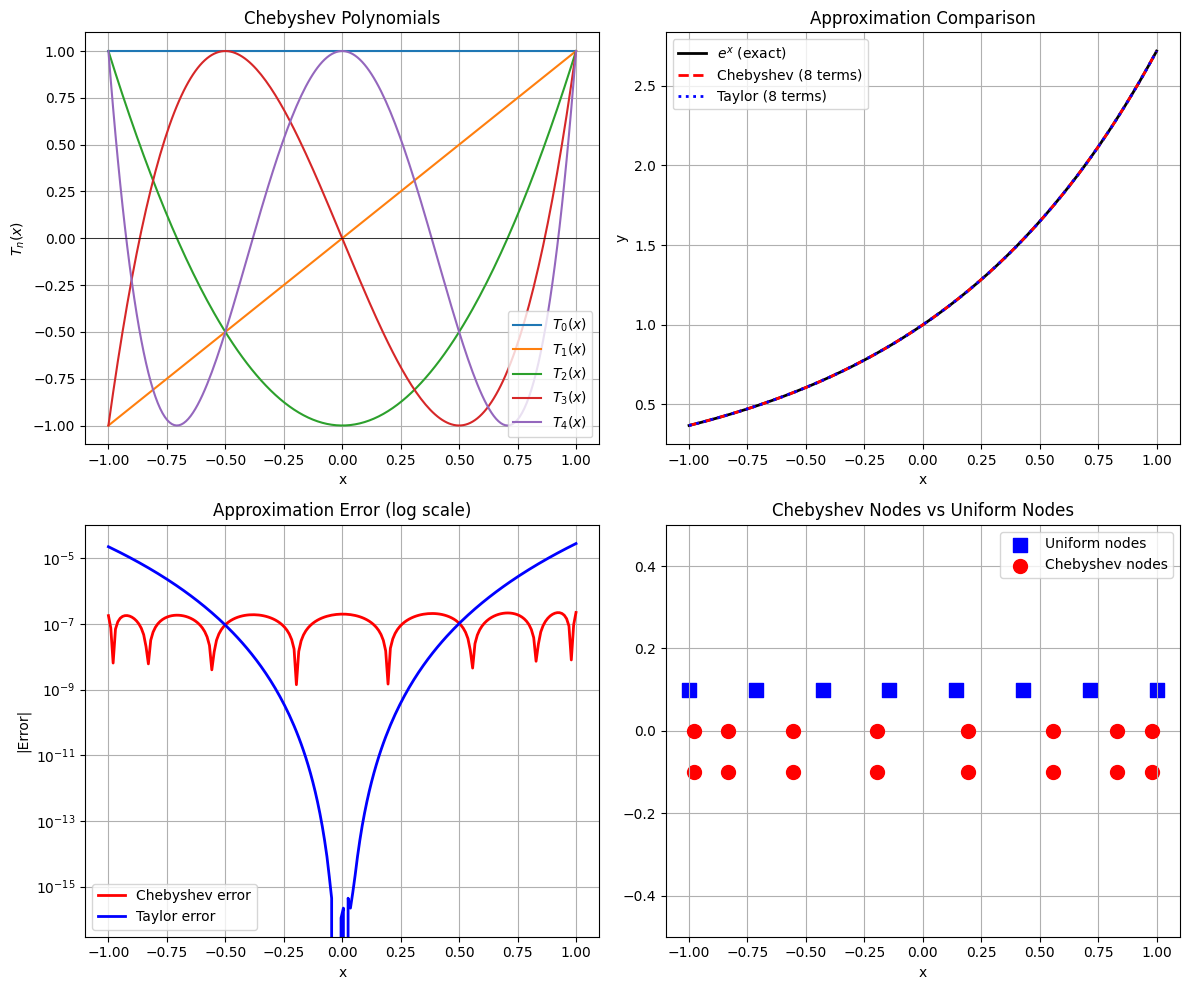


Max error (Chebyshev): 2.22e-07
Max error (Taylor):    2.79e-05


In [19]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Chebyshev polynomials
x_plot = np.linspace(-1, 1, 200)
for n in range(5):
    axes[0, 0].plot(x_plot, chebyshev_polynomial(n, x_plot), label=f'$T_{n}(x)$')
axes[0, 0].set(xlabel='x', ylabel='$T_n(x)$', title='Chebyshev Polynomials')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].axhline(0, color='k', linewidth=0.5)

# Plot 2: Function and approximations
axes[0, 1].plot(x, y_true, 'k-', label='$e^x$ (exact)', linewidth=2)
axes[0, 1].plot(x, y_cheb, 'r--', label=f'Chebyshev ({n_terms} terms)', linewidth=2)
axes[0, 1].plot(x, y_taylor, 'b:', label=f'Taylor ({n_terms} terms)', linewidth=2)
axes[0, 1].set(xlabel='x', ylabel='y', title='Approximation Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Approximation errors
error_cheb = np.abs(y_true - y_cheb)
error_taylor = np.abs(y_true - y_taylor)
axes[1, 0].semilogy(x, error_cheb, 'r-', label='Chebyshev error', linewidth=2)
axes[1, 0].semilogy(x, error_taylor, 'b-', label='Taylor error', linewidth=2)
axes[1, 0].set(xlabel='x', ylabel='|Error|', title='Approximation Error (log scale)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Chebyshev nodes
nodes = chebyshev_nodes(n_terms)
axes[1, 1].scatter(nodes, np.zeros_like(nodes), s=100, c='red', zorder=5)
axes[1, 1].scatter(np.linspace(-1, 1, n_terms), np.ones(n_terms)*0.1, s=100, c='blue', marker='s', label='Uniform nodes')
axes[1, 1].scatter(nodes, -np.ones_like(nodes)*0.1, s=100, c='red', marker='o', label='Chebyshev nodes')
axes[1, 1].set(xlabel='x', title='Chebyshev Nodes vs Uniform Nodes')
axes[1, 1].set_ylim(-0.5, 0.5)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Summary
print(f"\nMax error (Chebyshev): {np.max(error_cheb):.2e}")
print(f"Max error (Taylor):    {np.max(error_taylor):.2e}")